In [13]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import pchip_interpolate as pch

In [14]:
C_q1 = 3 #unitless, referencing kang's paper for ballpark region estimate
C_q2 = -0.000002 #unitless
q = lambda P: 1 + C_q1 * np.exp(C_q2*P) #q correction factor

L_a = 0.30 #meters
eps = lambda L: (L_a - L)/(L_a) #strain

alpha_0 = 23*np.pi/180 #degrees to radians

D_0 = 0.010 #meters
C_1 = (np.pi*D_0**2)/(4.0)
C_2 = (3)/(np.tan(alpha_0)**2)
C_3 = (1)/(np.sin(alpha_0)**2)
C_4 = C_1*C_2
C_5 = C_1*C_3 

L_fpdf = L_a * 0.9 #length for complementary percent of deformation
def f_a(P, L):
    return P*C_4*(1+(q(P)**2)*(eps(L)**2) - 2*q(P)*eps(L)) - P*C_5

f_a(800000, L_fpdf)
pressures = np.arange(0, 8+1, 1)*100000 #bar to pa
strain = np.linspace(0, 25, 100)/100 #percent to decimal strain
lengths = L_a - L_a*strain

In [15]:
#Lineararize at the actuator length, at 300000 pa / 3 bar
e = -0.10 #linearize at -10% strain
L_0 = L_a + L_a*e
P_g0 = 300000

#Compute the linearized coefficients

Q1p1 = C_4-C_5-2*C_4*((L_a-L_0)/L_a)-2*C_4*((L_a-L_0)/(L_a))*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
Q1p2 = C_4+C_4*(C_q1**2)*(np.exp(2*C_q2*P_g0)+2*(P_g0)*C_q2*np.exp(2*C_q2*P_g0))
Q1p3 = 2*C_4*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
Q1pend = ((L_a**2 + L_0**2 - 2*L_0*L_a)/(L_a**2))
Q_1=Q1p1+(Q1p2 + Q1p3)*Q1pend

Q_2 = (2*P_g0*C_4)/(L_a) + ((2*P_g0*C_4*C_q1)/(L_a))*np.exp(C_q2*P_g0)+(P_g0*C_4+P_g0*C_4*(C_q1**2)*np.exp(2*C_q2*P_g0) + 2*P_g0*C_4*C_q1*np.exp(C_q2*P_g0))*((2*L_0)/(L_a**2) - 2/L_a)

lin_model = lambda dP, dL: Q_1*(dP)+Q_2*(dL)
delta_p = -3614.4578313253005
delta_l = -0.0019879518072289186 #meters

f_0 = f_a(P_g0, L_0)

eqn_result = f_a(P_g0+delta_p, L_0+delta_l)
lin_result = f_0+lin_model(delta_p, delta_l)

def calc_lin_model(L_0, P_0):
    #global lin_model
    Q1p1 = C_4-C_5-2*C_4*((L_a-L_0)/L_a)-2*C_4*((L_a-L_0)/(L_a))*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1p2 = C_4+C_4*(C_q1**2)*(np.exp(2*C_q2*P_g0)+2*(P_g0)*C_q2*np.exp(2*C_q2*P_g0))
    Q1p3 = 2*C_4*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1pend = ((L_a**2 + L_0**2 - 2*L_0*L_a)/(L_a**2))
    Q_1=Q1p1+(Q1p2 + Q1p3)*Q1pend
    lin_model = lambda dP, dL: Q_1*(dP)+Q_2*(dL)
    return lin_model

print(f"Q1: {Q_1}, Q_2: {Q_2}\nF_0: {f_0}")
print(f"Eqn: {eqn_result}, lin_model: {lin_result}")
print(f"perror: {100*abs((eqn_result-lin_result)/(eqn_result))}")

Q1: 0.0003826875046445771, Q_2: 5089.749769888915
F_0: 57.80921358672626
Eqn: 46.52756717289523, lin_model: 46.30782848521969
perror: 0.4722763321344553


/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97118/2183566622.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  p_e = 100*abs(nlin_result[y,x]-lin_result[y,x])/abs(nlin_result[y,x])
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97118/2183566622.py:31: RuntimeWarning: divide by zero encountered in divide
  perror = abs(100*(nlin_result-lin_result)/(nlin_result))


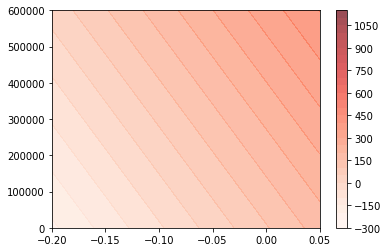

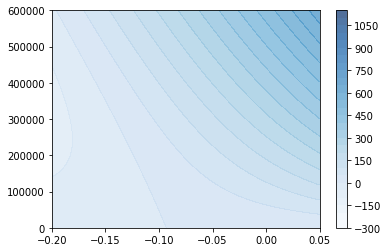

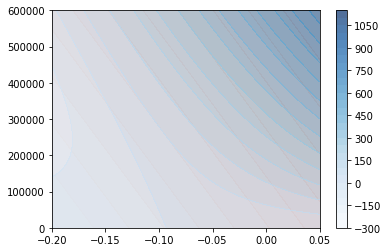

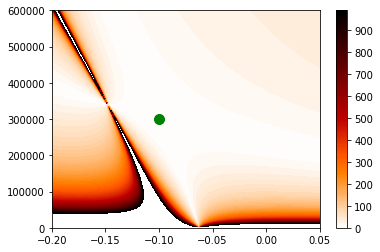

In [16]:
pressures = np.linspace(0,600000,250)
strains = np.linspace(-0.2,0.05,250)

lin_result = np.zeros((len(pressures), len(strains)))
nlin_result = np.zeros((len(pressures), len(strains)))
perror = np.zeros(lin_result.shape)

for y, p in enumerate(pressures):
    for x, s in enumerate(strains):
        delta_p = p-P_g0
        delta_l = L_a*(s-e)
        f_0 = f_a(P_g0, L_0)
        nlin_result[y,x] = f_a(p, L_a+s*L_a)
        lin_result[y,x] = f_0+lin_model(delta_p, delta_l)
        p_e = 100*abs(nlin_result[y,x]-lin_result[y,x])/abs(nlin_result[y,x])
        perror[y,x]=p_e

plt.figure()
plt.contourf(strains, pressures, lin_result, np.arange(-300, 1200, 50), cmap="Reds", alpha=0.7)
plt.colorbar()
plt.figure()
plt.contourf(strains, pressures, nlin_result,np.arange(-300, 1200, 50), cmap="Blues", alpha=0.7)
plt.colorbar()
plt.figure()
plt.contourf(strains, pressures, lin_result, np.arange(-300, 1200, 50), cmap="Reds", alpha=0.7)
#plt.colorbar()
#plt.figure()
plt.contourf(strains, pressures, nlin_result,np.arange(-300, 1200, 50), cmap="Blues", alpha=0.7)
plt.colorbar()
plt.figure()
perror = abs(100*(nlin_result-lin_result)/(nlin_result))
plt.contourf(strains, pressures, perror,np.arange(0,1000,10),cmap="gist_heat_r")
plt.colorbar()
plt.plot(e,P_g0, 'go', markersize=10)

In [17]:
#idx = (abs(s_mg - e) < 0.001)
x = abs(strains*L_a - L_0) < 0.001
y = abs(pressures - P_g0/100000.0) < 0.1
idx = y[:,None] == x
print(f"s {np.round(strains[x],3)}")
print(f"p {np.round(pressures[y])}")
print(f"dl {np.round((L_0*strains)[x], 3)}")
print(f"dp {np.round((P_g0-pressures)[y],3)}")
print(lin_result.shape)
print(f"lin {np.round(lin_result[idx],2)}")
print(f"nlin {np.round(nlin_result[idx],2)}")
print(f"perror {np.round(perror[idx],2)}")

s []
p []
dl []
dp []
(250, 250)
lin [-209.69 -208.16 -206.62 ...  398.59  400.12  401.65]
nlin [  0.     0.     0.   ... 625.86 629.14 632.42]
perror [  inf   inf   inf ... 36.31 36.4  36.49]


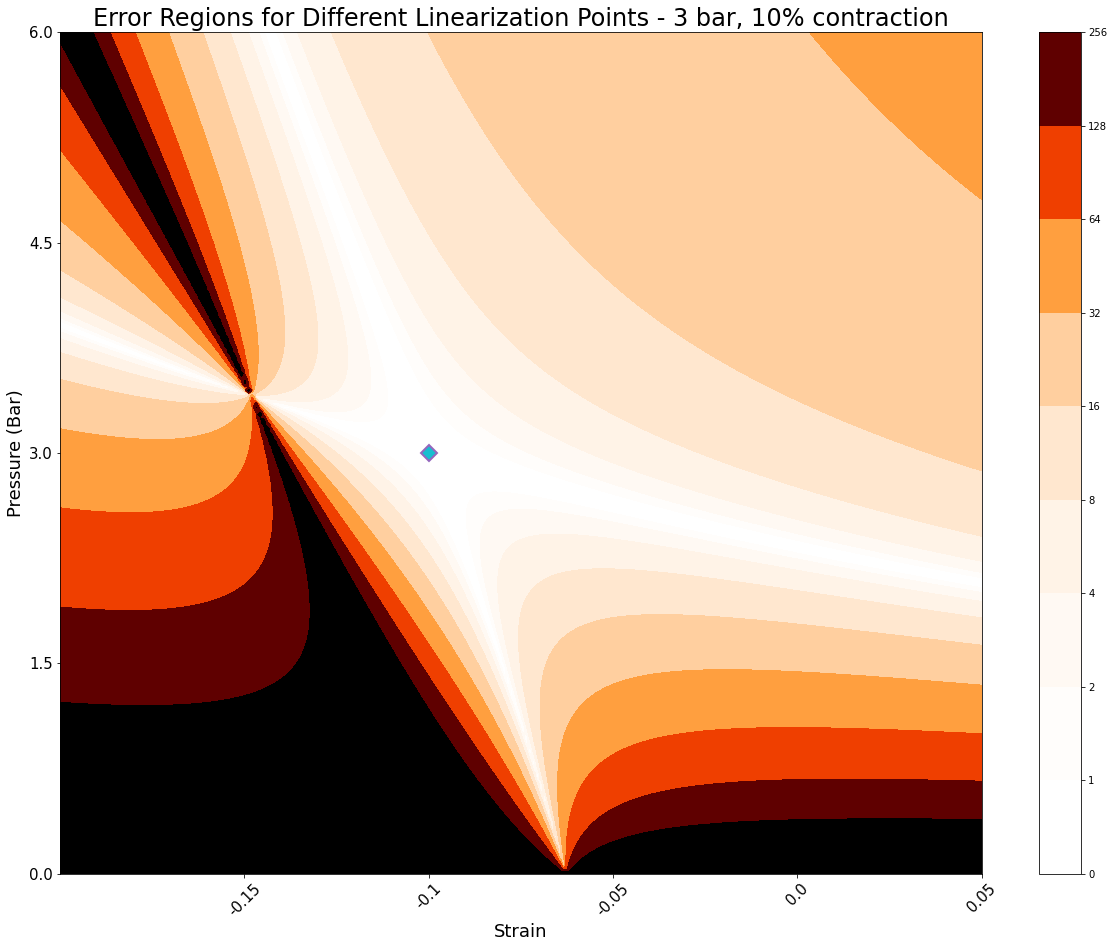

In [18]:
fig, axes = plt.subplots(figsize=(20,14))
base = 2
exp = np.arange(0,9,1)
legend = np.insert(np.power(base,exp),0,0)
old_leg = [0,5,10,20,40,50,100,200]
ctf = axes.contourf(strains, pressures, perror, legend,cmap="gist_heat_r")
axes.plot(e, P_g0, linestyle=":",color="tab:purple", marker="D", markersize=12, markerfacecolor="tab:cyan",markeredgewidth=2)
axes.set_facecolor('k')
fig.colorbar(ctf)
axes.set_title("Error Regions for Different Linearization Points - 3 bar, 10% contraction", fontsize=24)
h = axes
h.set_ylabel("Pressure (Bar)", fontsize=18)
y_ticks = np.linspace(0,600000,5)
h.set_yticks(y_ticks)
h.axes.yaxis.set_ticklabels([round(elem/100000, 1) for elem in y_ticks], fontsize=10)
h.tick_params(axis='y', which='major', labelsize=15)
h.set_xlabel("Strain", fontsize=18)
x_ticks = np.linspace(-0.15,0.05,5)
h.set_xticks(x_ticks, fontsize=10, rotation=45)
h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks], fontsize=10)
h.tick_params(axis='x', which='major', labelsize=15, rotation=45)
plt.subplots_adjust(top=0.935, left=0.1, right=0.9, bottom=0.1)
fig.patch.set_facecolor([1,1,1])
plt.savefig("figures/lin_error_ex.png", dpi=300)

In [19]:
center_pressures = [200000, 250000, 300000, 350000, 400000]
center_strains = [-0.2, -0.15, -0.1, -0.05, 0.0, 0.05]

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97118/699485163.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  p_e = 100*abs(nlin_result[y,x]-lin_result[y,x])/abs(nlin_result[y,x])


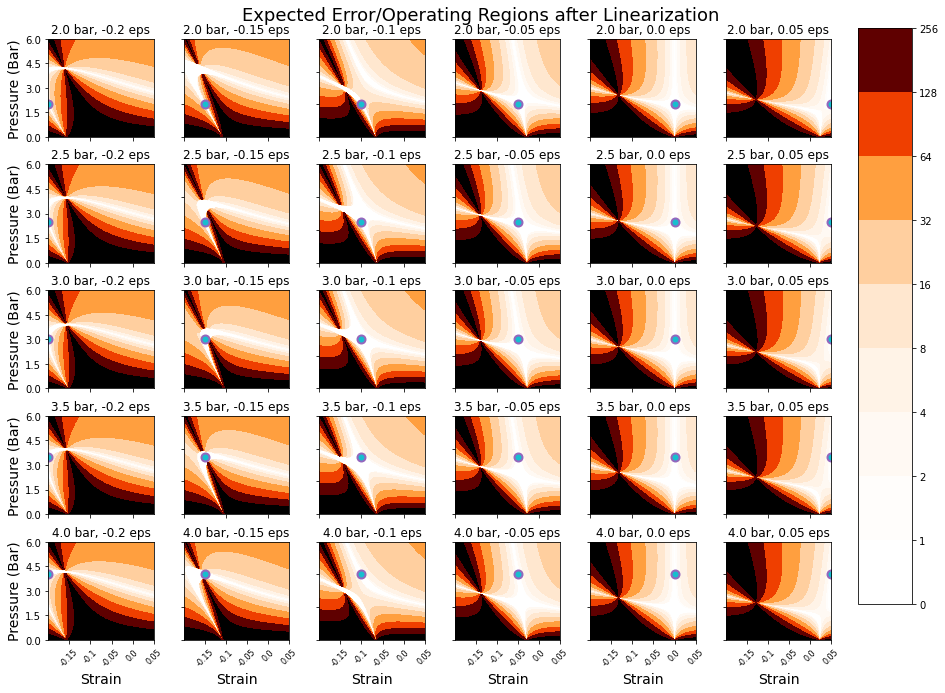

In [23]:
data = dict()
pressures = np.linspace(0,600000,150)
strains = np.linspace(center_strains[0],center_strains[-1],150)
fig, axes = plt.subplots(nrows=len(center_pressures), ncols=len(center_strains), figsize=(15,10))
fig.tight_layout(pad=1, w_pad=0.2, h_pad=1.0)
for row, cp in enumerate(center_pressures):
    for col, cs in enumerate(center_strains):
        L_0 = L_a + L_a*cs
        lin_model = calc_lin_model(L_0, cp)
        f_0 = f_a(cp, L_0)
        
        lin_result = np.zeros((len(pressures), len(strains)))
        nlin_result = np.zeros((len(pressures), len(strains)))
        perror = np.zeros(lin_result.shape)
        for y, p in enumerate(pressures):
            for x, s in enumerate(strains):
                delta_p = p-cp
                delta_l = L_a*(s-cs)
                f_0 = f_a(cp, L_0)
                nlin_result[y,x] = f_a(p, L_a+s*L_a)
                lin_result[y,x] = f_0+lin_model(delta_p, delta_l)
                if abs(nlin_result[y,x]-lin_result[y,x]) < 3:
                    p_e = 0
                else:
                    p_e = 100*abs(nlin_result[y,x]-lin_result[y,x])/abs(nlin_result[y,x])
                
                perror[y,x]=p_e
        
        perror[perror == -np.inf] = 1000
        perror[perror == np.inf] = 1000
        
        
        h = axes[row][col]
        base = 2
        exp = np.arange(0,9,1)
        legend = np.insert(np.power(base,exp),0,0)
        old_legend = [0,5,10,20,40,50,100,200, 500]
        ctf = h.contourf(strains, pressures, perror, legend,cmap="gist_heat_r")
        h.set_facecolor('k')
        h.set_title(f"{round(cp/100000, 2)} bar, {round(cs,2)} eps")
        h.plot(cs, cp, linestyle=":",color="tab:purple", marker="o", markersize=8, markerfacecolor="tab:cyan",markeredgewidth=2)
        
        if col == 0:
            h.set_ylabel("Pressure (Bar)", fontsize=14)
            y_ticks = np.linspace(0,600000,5)
            h.set_yticks(y_ticks)
            h.axes.yaxis.set_ticklabels([round(elem/100000, 1) for elem in y_ticks])
            h.tick_params(axis='y', which='major', labelsize=10)
        else:
            h.axes.yaxis.set_ticklabels([])
            
        if row == len(center_pressures)-1:
            h.set_xlabel("Strain", fontsize=14)
            x_ticks = np.linspace(-0.15,0.05,5)
            h.set_xticks(x_ticks, fontsize=10, rotation=45)
            h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks])
            h.tick_params(axis='x', which='major', labelsize=8, rotation=45)
        else:
            h.axes.xaxis.set_ticklabels([])
            
        h.set_ylim((0,600000))
        h.set_xlim((center_strains[0], center_strains[-1]))
        
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.8])
fig.colorbar(ctf, cax=cbar_ax)
plt.subplots_adjust(top=0.935, left=0.1, right=0.825, bottom=0.1)
fig.suptitle("Expected Error/Operating Regions after Linearization", fontsize=18, x=0.5, y=0.98)
plt.savefig("figures/lin_errors_samples.png", dpi=300)